## Example of dowhy on our dataset

Code Reference
- Amit Sharma, Emre Kiciman. DoWhy: An End-to-End Library for Causal Inference. 2020. https://arxiv.org/abs/2011.04216

In [1]:
import pandas as pd
import numpy as np
import dowhy
from dowhy import CausalModel
import warnings
warnings.filterwarnings("ignore")

In [2]:
student_data = pd.read_csv("data.csv")
student_data.shape

In [3]:
student_data['performance'] = student_data[['math score', 'reading score', 'writing score']].mean(axis=1)
student_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,performance
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


## Dowhy can not process catagorical data, so one hot transform is needed

In [4]:
student_data['performance'] = student_data['performance'].apply(lambda x: 1 if x > student_data["performance"].median() else 0)

In [5]:
student_data['test preparation course'] = student_data['test preparation course'].map({'none': 0, 'completed': 1})
student_data['gender'] = student_data['gender'].map({'female': 0, 'male': 1})
student_data['lunch'] = student_data['lunch'].map({'standard': 0, 'free/reduced': 1})
student_data["parental level of education"] = student_data["parental level of education"].map({"bachelor's degree":1,'some college':1,"master's degree":1,"associate's degree":0, 'high school':0, 'some high school':0 })
student_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,performance
0,0,group B,1,0,0,72,72,74,1
1,0,group C,1,0,1,69,90,88,1
2,0,group B,1,0,0,90,95,93,1
3,1,group A,0,1,0,47,57,44,0
4,1,group C,1,0,0,76,78,75,1


In [6]:
student_data['parental level of education'].unique()

array([1, 0])

## We only consider gender and test preparation course as confounders

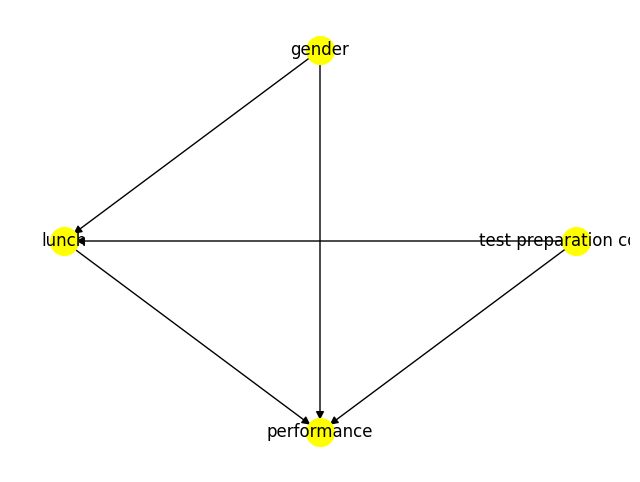

In [7]:
model0 = CausalModel(
    data=student_data,
    treatment='lunch',
    outcome='performance',
    common_causes=['test preparation course',"gender"]
)
model0.view_model()

In [8]:
identified_estimand = model0.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                   
────────(E[performance|gender,test preparation course])
d[lunch]                                               
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→performance then P(performance|lunch,gender,test preparation course,U) = P(performance|lunch,gender,test preparation course)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
estimate = model0.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")
print(estimate)

propensity_score_stratification
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                   
────────(E[performance|gender,test preparation course])
d[lunch]                                               
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→performance then P(performance|lunch,gender,test preparation course,U) = P(performance|lunch,gender,test preparation course)

## Realized estimand
b: performance~lunch+gender+test preparation course
Target units: ate

## Estimate
Mean value: -0.23279896714507659



## When we consider more outcomes

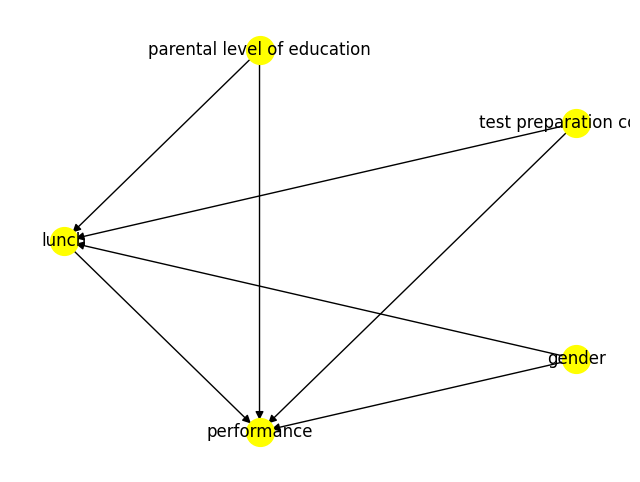

In [11]:
model1 = CausalModel(
    data=student_data,
    treatment='lunch',
    outcome='performance',
    common_causes=['gender', 'test preparation course',"parental level of education"]
)
model1.view_model()

In [12]:
identified_estimand = model1.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(E[performance|gender,test preparation course,parental level of educat
d[lunch]                                                                      

     
ion])
     
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→performance then P(performance|lunch,gender,test preparation course,parental level of education,U) = P(performance|lunch,gender,test preparation course,parental level of education)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [13]:
estimate = model1.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")

propensity_score_stratification


In [14]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(E[performance|gender,test preparation course,parental level of educat
d[lunch]                                                                      

     
ion])
     
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→performance then P(performance|lunch,gender,test preparation course,parental level of education,U) = P(performance|lunch,gender,test preparation course,parental level of education)

## Realized estimand
b: performance~lunch+gender+test preparation course+parental level of education
Target units: ate

## Estimate
Mean value: -0.23390292301801996



## Methods of refuting the estimate obtained

In [16]:
res_random=model1.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.23390292301801996
New effect:-0.23498916402899056
p value:0.8600000000000001



### Explain

Based on the results, I performed a "refute" analysis by Adding a random common cause. The estimated effect is -0.23390292301801996, and the new effect after using the subset is -0.0.23498916402899056(This indicates the effect obtained when Adding a random common cause). They are pretty close. Moreover, the p-value is reported as 0.86, suggestiing here is no strong evidence to support the claim that the new effect is significantly different from the estimated effect.

In [17]:
res_subset=model1.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.23390292301801996
New effect:-0.23253346422602977
p value:0.88



### Explaination

Based on the results, I performed a "refute" analysis using a subset of the data. The estimated effect is -0.23390292301801996, and the new effect after using the subset is -0.23253346422602977(This indicates the effect obtained when considering only a portion of the data). They are pretty close. Moreover, the p-value is reported as 0.88, suggestiing here is no strong evidence to support the claim that the new effect is significantly different from the estimated effect.

From the results, such way of estimator is good, because it pass the significant test. 

## conclusion

According to our estimator results, lunch type of (free/reduced) do have negaitive effect on how the students perform the exam.  Recall that our method in this project by backdoor do calculus have 95% range [-0.31, -0.20], and backdoor estimator by linear regression has 95% range [-0.28, -0.17]. So I think this is a pretty good result and I think we can apply such library here. 